## Analyze bulk RNA-seq

In [2]:
library(stringr)
library(data.table)
require(gdata)
library(readr)
library(ggplot2)
library(gridExtra)
library(cowplot)
require(scales)
library(ggplot2)
library(dplyr)
library(stringr)
library(matrixStats)
library(viridis)
library(patchwork)
library(RColorBrewer)
library(limma)
library(pbapply)
library(parallel)
library(ggrepel)
library(limma)
library(Rtsne)
library(stringr)
library(data.table)
library(harmony)
library(magrittr)
library(gridExtra)
library(ggthemes)
# library(monocle)
library(reticulate)
library(ggbeeswarm)
library(ggrepel)
library(plyr)
library(ggplot2)
library(gridExtra)
library(ggthemes)
library(dplyr)

library(RColorBrewer)
library(ggbeeswarm)
library(ggrepel)
library(MASS)
library(matrixStats)
library(viridis)
library(grid)
library(umap)

library(farver)
library(stringr)
library(data.table)
require(gdata)

source("/data/srlab/fzhang/amp/results/2017_02_28_Phase1_cellseq_RA_single_cell_data/pure_functions.R")
source("/data/srlab/fzhang/amp/results/2017_01_12_Low_input_RA_RNA_seq_data_analysis/pca_Kam.R")

In [3]:
# Functions

# FindVariableGenesBatch <- function(exprs_mat, meta_df, cell_col = "cell_id",
#                                    batch_col = "sample_id", ngenes_use = 1e3, expr_min = .1) {
#     x_res <- split(meta_df[[cell_col]], meta_df[[batch_col]]) %>% lapply(function(x) {
#         FindVariableGenesSeurat(exprs_mat[, x]) %>%
#             subset(gene.mean >= expr_min) %>%
#             tibble::rownames_to_column("gene") %>%
#             dplyr::arrange(-gene.dispersion) %>%
#             head(ngenes_use)
#     })
#     data.table(Reduce(rbind, x_res))[, .N, by = gene][order(-N)]
# }

FindVariableGenesBatch <- function(exprs_mat, meta_df, genes_exclude = NULL, ngenes_use = 1e3, expr_min = .1) {
    if (!is.null(genes_exclude)) {
        genes_use <- setdiff(row.names(exprs_mat), genes_exclude)
    }
    x_res <- split(meta_df$cell, meta_df$sample) %>% lapply(function(x) {
        FindVariableGenesSeurat(exprs_mat[genes_use, x]) %>% 
            subset(gene.mean >= expr_min) %>% 
            tibble::rownames_to_column("gene") %>% 
            dplyr::arrange(-gene.dispersion) %>%
            head(ngenes_use)
    })
    data.table(Reduce(rbind, x_res))[, .N, by = gene][order(-N)]    
}



FindVariableGenesSeurat <- function (data, x.low.cutoff = 0.1, x.high.cutoff = 8,
                                     y.cutoff = 1, y.high.cutoff = Inf, num.bin = 0,
                                     binning.method = "equal_width", sort.results = TRUE,
                                     display.progress = TRUE, ...)
{
    genes.use <- rownames(data)
    if (class(data) != "dgCMatrix") {
        data <- as(as.matrix(data), "dgCMatrix")
    }
    ## (1) get means and variances
    gene.mean <- FastExpMean(data, display.progress)
    names(gene.mean) <- genes.use
    gene.dispersion <- FastLogVMR(data, display.progress)
    names(gene.dispersion) <- genes.use

    gene.dispersion[is.na(x = gene.dispersion)] <- 0
    gene.mean[is.na(x = gene.mean)] <- 0

    mv.df <- data.frame(gene.mean, gene.dispersion)
    rownames(mv.df) <- rownames(data)

    ## (OPTIONAL) do the binning correction
    if (num.bin > 0) {
      if (binning.method == "equal_width") {
          data_x_bin <- cut(x = gene.mean, breaks = num.bin)
      }
      else if (binning.method == "equal_frequency") {
          data_x_bin <- cut(x = gene.mean, breaks = c(-1, quantile(gene.mean[gene.mean >
              0], probs = seq(0, 1, length.out = num.bin))))
     }
      else {
          stop(paste0("Invalid selection: '", binning.method,
              "' for 'binning.method'."))
      }
      names(x = data_x_bin) <- names(x = gene.mean)
      mean_y <- tapply(X = gene.dispersion, INDEX = data_x_bin,
          FUN = mean)
      sd_y <- tapply(X = gene.dispersion, INDEX = data_x_bin,
          FUN = sd)
      gene.dispersion.scaled <- (gene.dispersion - mean_y[as.numeric(x = data_x_bin)])/sd_y[as.numeric(x = data_x_bin)]
      gene.dispersion.scaled[is.na(x = gene.dispersion.scaled)] <- 0
      ##names(gene.dispersion.scaled) <- names(gene.mean)

      mv.df$gene.dispersion.scaled <- gene.dispersion.scaled
    }

    return(mv.df)
}

environment(FindVariableGenesSeurat) <- asNamespace("Seurat")

ScaleDataSeurat <- function (data.use, margin = 1, scale.max = 10,
                                block.size = 1000) {

    if (margin == 2) data.use %<>% t
    max.block <- ceiling(nrow(data.use)/block.size)

    ## Define data and functions to use in sparse and dense cases
    if (class(data.use) == "dgCMatrix" | class(data.use) == "dgTMatrix") {
        scale_fxn <- function(x) {
            FastSparseRowScale(mat = x, scale = TRUE, center = TRUE,
                               scale_max = scale.max, display_progress = FALSE)
        }
    } else {
        scale_fxn <- function(x) {
            FastRowScale(mat = x, scale = TRUE, center = TRUE,
                               scale_max = scale.max, display_progress = FALSE)
       }
        data.use <- as.matrix(data.use)
    }

    ## Do scaling, at once or in chunks
    if (max.block == 1) {
        scaled.data <- scale_fxn(data.use)
    } else {
        scaled.data <- matrix(NA, nrow(data.use), ncol(data.use))
        for (i in 1:max.block) {
            idx.min <- (block.size * (i - 1))
            idx.max <- min(nrow(data.use), (block.size * i - 1) + 1)
            my.inds <- idx.min:idx.max
            scaled.data[my.inds, ] <- scale_fxn(data.use[my.inds, , drop = F])
        }
    }

    colnames(scaled.data) <- colnames(data.use)
    row.names(scaled.data) <- row.names(data.use)
    scaled.data[is.na(scaled.data)] <- 0
    if (margin == 2) scaled.data %<>% t
    return(scaled.data)
}
environment(ScaleDataSeurat) <- asNamespace("Seurat")


fig.size <- function(height, width) {
    options(repr.plot.height = height, repr.plot.width = width)
}

SingleFeaturePlotSeurat <- function (data.use, feature, data.plot, pt.size, pch.use, cols.use,
    dim.codes, min.cutoff, max.cutoff, coord.fixed, no.axes,
    no.title = FALSE, no.legend, dark.theme, vector.friendly = FALSE,
    png.file = NULL, png.arguments = c(10, 10, 100))
{
    if (vector.friendly) {
        previous_call <- blank_call <- png_call <- match.call()
        blank_call$pt.size <- -1
        blank_call$vector.friendly <- FALSE
        png_call$no.axes <- TRUE
        png_call$no.legend <- TRUE
        png_call$vector.friendly <- FALSE
        png_call$no.title <- TRUE
        blank_plot <- eval(blank_call, sys.frame(sys.parent()))
        png_plot <- eval(png_call, sys.frame(sys.parent()))
        png.file <- SetIfNull(x = png.file, default = paste0(tempfile(),
            ".png"))
        ggsave(filename = png.file, plot = png_plot, width = png.arguments[1],
            height = png.arguments[2], dpi = png.arguments[3])
        to_return <- AugmentPlot(blank_plot, png.file)
        file.remove(png.file)
        return(to_return)
    }
    idx.keep <- which(!is.na(data.use[feature, ]))
    data.gene <- data.frame(data.use[feature, idx.keep])
#     data.gene <- na.omit(object = data.frame(data.use[feature,
#         ]))
    min.cutoff <- SetQuantile(cutoff = min.cutoff, data = data.gene)
    max.cutoff <- SetQuantile(cutoff = max.cutoff, data = data.gene)
    data.gene <- sapply(X = data.gene, FUN = function(x) {
        return(ifelse(test = x < min.cutoff, yes = min.cutoff,
            no = x))
    })
    data.gene <- sapply(X = data.gene, FUN = function(x) {
        return(ifelse(test = x > max.cutoff, yes = max.cutoff,
            no = x))
    })
    data_plot <- data.plot[idx.keep, ]
    data_plot$gene <- data.gene
    if (length(x = cols.use) == 1) {
        brewer.gran <- brewer.pal.info[cols.use, ]$maxcolors
    }
    else {
        brewer.gran <- length(x = cols.use)
    }
    if (all(data.gene == 0)) {
        data.cut <- 0
    }
    else {
        data.cut <- as.numeric(x = as.factor(x = cut(x = as.numeric(x = data.gene),
            breaks = brewer.gran)))
    }
    data_plot$col <- as.factor(x = data.cut)
    p <- data_plot %>%
        dplyr::arrange(col) %>%
        ggplot(mapping = aes(x = x, y = y))
    if (brewer.gran != 2) {
        if (length(x = cols.use) == 1) {
            p <- p + geom_point(mapping = aes(color = col), size = pt.size,
                shape = pch.use) + #scale_color_brewer(palette = cols.use)
                scale_color_viridis(option = "plasma", end = .9)
        }
        else {
            p <- p + geom_point(mapping = aes(color = col), size = pt.size,
                shape = pch.use) + #scale_color_manual(values = cols.use)
                scale_color_viridis(option = "plasma", end = .9)
        }
    }
    else {
        if (all(data_plot$gene == data_plot$gene[1])) {
            warning(paste0("All cells have the same value of ",
                feature, "."))
            p <- p + geom_point(color = cols.use[1], size = pt.size,
                shape = pch.use)
        }
        else {
            p <- p + geom_point(mapping = aes(color = gene),
                size = pt.size, shape = pch.use) + scale_color_viridis(option = "plasma", end = .9
    )
        }
    }
    if (dark.theme) {
        p <- p + DarkTheme()
    }
    if (no.axes) {
        p <- p + theme(axis.line = element_blank(), axis.text.x = element_blank(),
            axis.text.y = element_blank(), axis.ticks = element_blank(),
            axis.title.x = element_blank(), axis.title.y = element_blank())
        if (!no.title)
            p <- p + labs(title = feature, x = "", y = "")
        if (no.title)
            p <- p + labs(x = "", y = "")
    }
    else {
        if (no.title)
            p <- p + labs(x = dim.codes[1], y = dim.codes[2])
        if (!(no.title))
            p <- p + labs(title = feature) + labs(x = "", y = "")
    }
    if (no.legend) {
        p <- p + theme(legend.position = "none")
    }
    if (coord.fixed) {
        p <- p + coord_fixed()
    }
    return(p)
}
environment(SingleFeaturePlotSeurat) <- asNamespace("Seurat")

PlotFeatures <- function(umap_use, features_plot, exprs_use, cells_use, ncols, pt_size = .5, pt_shape = ".", q_lo = "q10", q_hi = "q90") {
    if (missing(cells_use)) cells_use <- 1:nrow(umap_use)
    if (missing(ncols)) ncols <- round(sqrt(length(features_plot)))
    
    plt_list <- lapply(features_plot, function(feature_use) {
        SingleFeaturePlotSeurat(exprs_use[, cells_use], feature_use, data.frame(x = umap_use[cells_use, 1], y = umap_use[cells_use, 2]),
                                pt.size = pt_size, pch.use = pt_shape, cols.use = c("lightgrey", "blue"),
                                dim.codes = c("UMAP 1", "UMAP 2"), min.cutoff = c(q10 = q_lo), max.cutoff = c(q90 = q_hi),
                                coord.fixed = FALSE, no.axes = FALSE, dark.theme = FALSE, no.legend = TRUE)
    })
    plot_grid(plotlist = plt_list, ncol = ncols)
    #return(plt_list)
}

BuildSNNSeurat <- function (data.use, k.param = 30, prune.SNN = 1/15, nn.eps = 0) {
    my.knn <- nn2(data = data.use, k = k.param, searchtype = "standard", eps = nn.eps)
    nn.ranked <- my.knn$nn.idx

    snn_res <- ComputeSNN(nn_ranked = nn.ranked, prune = prune.SNN)
    rownames(snn_res) <- row.names(data.use)
    colnames(snn_res) <- row.names(data.use)
    return(snn_res)
}
environment(BuildSNNSeurat) <- asNamespace("Seurat")

NormalizeDataSeurat <- function(A, scaling_factor = 1e4, do_ftt = FALSE) {
	A@x <- A@x / rep.int(Matrix::colSums(A), diff(A@p))
    A@x <- scaling_factor * A@x
    if (do_ftt) {
        A@x <- sqrt(A@x) + sqrt(1 + A@x)
    } else {
        A@x <- log(1 + A@x)
    }
	return(A)
}


plot_clusters <- function(cluster_ids, labels, pt_size = 14, umap_use = umap_res, collapse_labels = FALSE) {
    cluster_table <- table(cluster_ids)
    clusters_keep <- names(which(cluster_table > 20))
    plt_df <- umap_use %>% data.frame() %>% cbind(cluster = cluster_ids) %>%
        subset(cluster %in% clusters_keep) 
    if (!missing(labels)) {
        if (collapse_labels) {
            plt_df$cluster <- labels[plt_df$cluster + 1]            
        } else {
            plt_df$cluster <- sprintf("c%d: %s", plt_df$cluster, labels[plt_df$cluster + 1])
        }
    }
    plt_df %>% 
        ggplot(aes(X1, X2, col = factor(cluster))) + geom_point(shape = '.', size = 6, alpha = .7) + 
        geom_label_repel(data = data.table(plt_df)[, .(X1 = mean(X1), X2 = mean(X2)), by = cluster], 
                   aes(label = cluster), size = pt_size, alpha = .8) + 
        theme_void() +
        theme(axis.line = element_line()) +
        guides(col = FALSE)
}

In [5]:
tpm <- readRDS("/data/srlab2/fzhang/results/2021-05-03_Helena_bulk_RNA/pipeline_analysis/bulk_abundance_genename_txi.rds")
tpm[1:4,1:4]

tpm_to_log2tpm <- function(x) log(x + 1)
log2tpm <- apply(as.data.frame(tpm), 2, tpm_to_log2tpm)
log2tpm[1:4,1:4]

,AAGAGGCA_AGAGGATA,AAGAGGCA_AGGCTTAG,AAGAGGCA_ATAGAGAG,AAGAGGCA_ATTAGACG
TSPAN6,26.21412,37.37621,56.07873,37.852473
TNMD,0.00000,0.00000,0.00000,0.000000
DPM1,24.12247,41.39221,48.30421,41.778859
SCYL3,10.29893,7.07162,4.85436,4.874225


,AAGAGGCA_AGAGGATA,AAGAGGCA_AGGCTTAG,AAGAGGCA_ATAGAGAG,AAGAGGCA_ATTAGACG
TSPAN6,3.303736,3.647438,4.044432,3.659772
TNMD,0.000000,0.000000,0.000000,0.000000
DPM1,3.223762,3.746965,3.898010,3.756044
SCYL3,2.424708,2.088354,1.767187,1.770574


In [41]:
dim(log2tpm)

[1] 42244    96

In [42]:
# write.table(log2tpm, file = paste("bulk_log2tpm_genename_txi", ".tsv", sep = ""),
#             row.names=T,col.names=T, quote = F, sep = "\t")

In [17]:
res <- readRDS("/data/srlab2/fzhang/results/2021-05-03_Helena_bulk_RNA/pipeline_analysis/bulk_ensembl83_txi.rds")
cd <- res$counts

In [25]:
meta_all <- data.frame(

    sample = colnames(log2tpm)

)

[1] 13504

sample,percentage
AAGAGGCA_AGAGGATA,0.9962974
AAGAGGCA_AGGCTTAG,0.9968898
AAGAGGCA_ATAGAGAG,0.9994816
AAGAGGCA_ATTAGACG,0.9909656


NULL

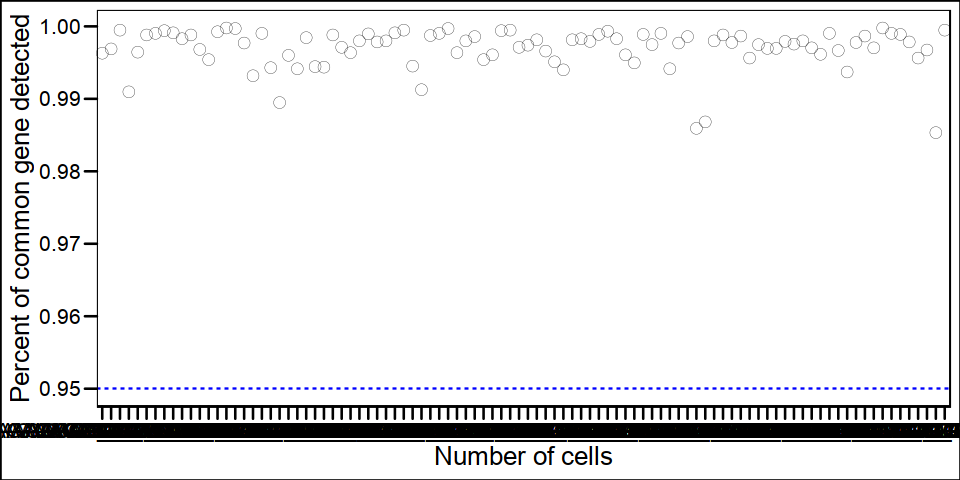

In [12]:
# Which genes are detected in 95% of samples? (# of non-zeros in log2tpm/ total # of samples)
nonzero_markers <- apply(log2tpm, 1, function(x) length(x[x>0])/length(x) > 0.95)
nonzero_genes <- log2tpm[nonzero_markers,]
common_genes <- rownames(nonzero_genes)
length(common_genes)
                         
# For a given sample, how many common genes are detected? (# of non-zeros in the common genes per sample/ total # of genes)
# If < 95%, that would be a BAD sample.
temp<-which(log2tpm[,1]>0)
common_index<-which(nonzero_markers, arr.ind=TRUE)

percentage <- array(0,dim=c(ncol(log2tpm)))
num_genes_det <- array(0,dim=c(ncol(log2tpm)))
  
for (i in 1:ncol(log2tpm)){
  temp<-which(log2tpm[,i]>0)
  num_genes_det[i] <- length(temp)
  inter<- intersect(common_index, temp)
  per<-length(inter)/length(common_genes)
  percentage[i] <- per
}
      
meta_all$percentage <- as.numeric(percentage)
meta_all[1:4,]
bad_index <- meta_all[which(meta_all$percentage < 0.95), ]$barcode
bad_index                
                         
options(repr.plot.width = 8, repr.plot.height = 4)                    
ggplot() +
    geom_point(
        data = meta_all[order(meta_all$percentage, decreasing = T),],
        mapping = aes(sample, percentage),
        shape = 21, size = 3, stroke = 0.1
    ) +
    geom_hline(yintercept = 0.95, color = "blue", linetype = "dashed") +
#     scale_fill_manual(values = c("#8DD3C7", "#FFFFB3", "#BEBADA", "#FB8072"), name = "") +
    labs(
         x = "Number of cells", y = "Percent of common gene detected"
        ) +
    theme_base(base_size = 15)

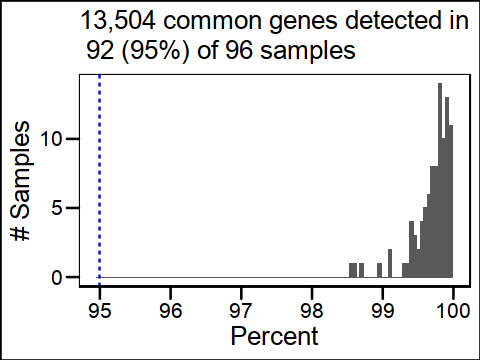

In [13]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(meta_all, aes(x = 100 * percentage)) +
geom_histogram(bins = 100) +
geom_vline(xintercept = 95, color = "blue", linetype = "dashed") +
scale_y_continuous(breaks = scales::pretty_breaks(4)) +
# coord_cartesian(xlim=c(80,100)) +
labs(
  x = "Percent", y = "# Samples", # title = "Percent of Common Genes",
  subtitle = sprintf(
    "%s common genes detected in\n %s (95%%) of %s samples",
    comma(length(common_genes)), ceiling(nrow(meta_all) * 0.95), nrow(meta_all)
  )
) +
theme_base(base_size = 15)
# ggsave("qc2.png", width = 5, height = 3, dpi = 300)

[1] 42244    96

[1] TRUE

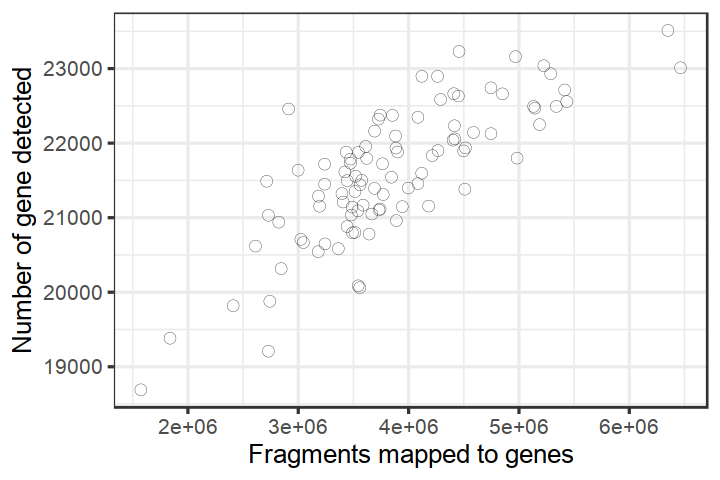

In [20]:
# Plot Mapped Fragments vs Genes Detected
# x-axis: reads/sample
# y-axis: counts of genes detected/sample

cd <- cd[, which(colnames(cd) %in% colnames(log2tpm))]
dim(cd)

dat <- data.frame(
  read_count = apply(cd, 2, function(x) sum(x)),
  nGene = Matrix::colSums(cd > 0),
  barcode = colnames(cd)
)
# assert that if the sample of the dat is the same as Sample.ID
all(dat$barcode == meta_all$barcode)
meta_all$read_count <- dat$read_count
meta_all$nGene <- dat$nGene
    
options(repr.plot.width = 6, repr.plot.height = 4)
ggplot() +
  geom_point(
    data = meta_all,
    mapping = aes(read_count, nGene),
    shape = 21, size = 3, stroke = 0.1
  ) + 
#   scale_fill_manual(values = c("#8DD3C7", "#FFFFB3", "#BEBADA", "#FB8072"), name = "") +
  xlab('Fragments mapped to genes')+ylab('Number of gene detected') +
#   coord_cartesian(xlim=c(0, 5e+07), ylim=c(800, 29000)) +
  theme_bw(base_size = 15) 


In [21]:
gene_summary <- data.frame(
  mean    = rowMeans(log2tpm),
  sd      = rowSds(log2tpm),
  samples = rowSums(log2tpm > 0),
  gene = rownames(log2tpm)
)
gene_summary$mean_quantile <- rank(gene_summary$mean) / nrow(gene_summary)
gene_summary$sd_quantile   <- rank(gene_summary$sd) / nrow(gene_summary)
gene_summary$density       <- with(gene_summary, get_density(mean, sd))

# ix_na <- is.na(gene_summary$gene)
# gene_summary$gene[ix_na] <- gene_summary$ensembl_id[ix_na]

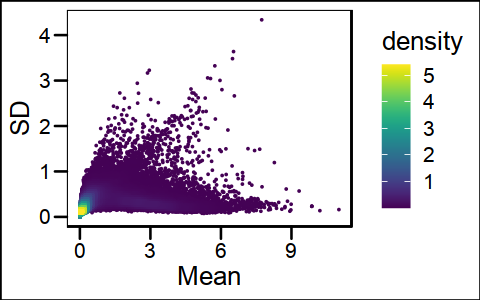

In [22]:
options(repr.plot.width = 4, repr.plot.height = 2.5)
ggplot(gene_summary[order(gene_summary$density),], aes(mean, sd, color = density)) +
scale_color_viridis() +
geom_point(size = 0.005) +
labs(x = "Mean", y = "SD") +
theme_base(base_size = 15)

In [32]:
ix_gene_mean <- gene_summary$mean > quantile(gene_summary$mean, 0.85)
ix_gene_sd <- gene_summary$sd > quantile(gene_summary$sd, 0.85)
scale_rows <- function(x) t(scale(t(x)))

temp <- log2tpm[ix_gene_mean & ix_gene_sd,]
genes_exclude <- grep("^MT-|^RPL|^RPS|MALAT1|MIR-", row.names(log2tpm), value = TRUE)
temp <- temp[-which(rownames(temp) %in% genes_exclude),]
dim(temp)

pca <- summary(prcomp(
  x = scale_rows(temp),
  center = TRUE,
  scale = TRUE
))

meta_all <- cbind.data.frame(meta_all, pca$rotation[,1:20])
pca_var_labs <- sprintf(
  "PC%s, %.02g%% of variance",
  variance_explained(pca)$Component,
  100 * variance_explained(pca)$Variance
)

meta_all[1:4, ]

[1] 1091   96

,sample,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
AAGAGGCA_AGAGGATA,AAGAGGCA_AGAGGATA,-0.004744793,0.1876867762,-0.001958994,0.10272311,-0.06704609,0.16334945,-0.05877752,0.02746875,-0.03586002,...,-0.17927503,0.001429642,-0.04429879,0.04986868,-0.07771378,0.04343707,-0.018307213,0.12882928,-0.10361554,0.03194874
AAGAGGCA_AGGCTTAG,AAGAGGCA_AGGCTTAG,-0.046035031,0.1613094863,0.104382493,-0.06946528,-0.12289540,0.08158757,-0.01736621,0.03213685,0.01606239,...,0.01877013,0.001587129,0.16845608,0.00421929,0.15306689,0.03678159,-0.004843606,0.19106071,0.08766494,0.07327852
AAGAGGCA_ATAGAGAG,AAGAGGCA_ATAGAGAG,-0.101916287,-0.0766422853,-0.170062314,0.02081600,-0.18576115,0.09945541,0.03052387,0.10498073,-0.07354417,...,-0.05312423,0.027402819,-0.04356278,-0.06042745,0.07584642,0.10010388,-0.057904026,-0.10259765,0.01086636,0.02098076
AAGAGGCA_ATTAGACG,AAGAGGCA_ATTAGACG,0.132881622,0.0001840992,0.073336184,-0.12376358,0.13628132,0.06444908,-0.02074633,0.20802926,0.07938742,...,-0.07753378,0.056546042,0.06622074,-0.04579298,0.05845857,0.01135925,-0.037772833,-0.07162553,-0.05343666,0.07443500


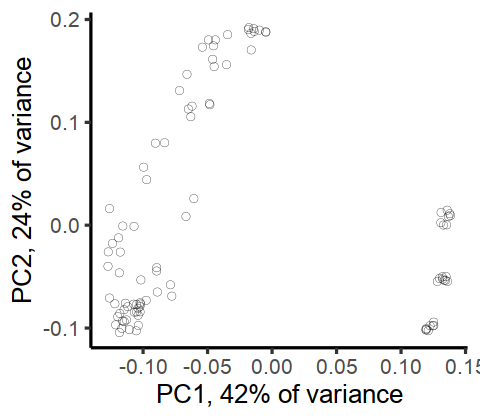

In [40]:
# Plot PCA results
options(repr.plot.height = 3.5, repr.plot.width = 4)
ggplot() +
  geom_point(
    data = meta_all,
    mapping = aes(PC1, PC2),
    shape = 21, size = 2, stroke = 0.1
  ) +
  labs(
      x = pca_var_labs[1],
      y = pca_var_labs[2]
    ) +
  theme_classic(base_size = 15)

# Previous code

In [70]:
# (1,000 cells of sorted monocytes, B cells, T cells, and fibroblasts; total of 88 samples or so from 22 patients)
bulk <- readRDS("/data/srlab1/fzhang/results/2020_amp2_lowinput_kallisto/collated_output/amp2_bulk_ensembl83_biomaRt_txi.rds")
bulk$abundance[1:4,1:4]
bulk$counts[1:4,1:4]

,AAGAGGCA_ACTCTAGG,AAGAGGCA_AGCTAGAA,AAGAGGCA_ATAGCCTT,AAGAGGCA_CTAGTCGA
A1BG,3.9267640,5.435295,9.20881900,15.0742780
A1CF,0.1319941,0.203454,0.05793423,0.1461021
A2M,9.1437100,2.009442,5.29279100,6.8050310
A2ML1,3.2555690,2.591799,1.65383380,0.7305430


,AAGAGGCA_ACTCTAGG,AAGAGGCA_AGCTAGAA,AAGAGGCA_ATAGCCTT,AAGAGGCA_CTAGTCGA
A1BG,26.845000,26.76044,29.794320,55.017230
A1CF,4.153922,7.14251,2.015791,6.066643
A2M,97.691910,12.00000,72.608588,86.999970
A2ML1,15.033250,15.57325,9.970650,9.045350


In [219]:
tpm_to_log2tpm <- function(x) log(x + 1)
log2tpm <- apply(as.data.frame(bulk$abundance), 2, tpm_to_log2tpm)
dim(log2tpm)
log2tpm[1:4,1:4]

[1] 41727    96

,AAGAGGCA_ACTCTAGG,AAGAGGCA_AGCTAGAA,AAGAGGCA_ATAGCCTT,AAGAGGCA_CTAGTCGA
A1BG,1.5946824,1.8617977,2.32325195,2.7772204
A1CF,0.1239807,0.1851958,0.05631817,0.1363667
A2M,2.3168538,1.1017547,1.83940469,2.0547685
A2ML1,1.4482285,1.2786532,0.97600531,0.5484352


In [74]:
tpm_to_log2cpm <- function(x) log(x*1e4 + 1)
log2cpm <- apply(as.data.frame(bulk$counts), 2, tpm_to_log2cpm)
log2cpm[1:4,1:4]


tpm_to_log2cpm <- function(x) log(x + 1)
log2cpm <- apply(as.data.frame(bulk$counts), 2, tpm_to_log2cpm)
log2cpm[1:4,1:4]

saveRDS(log2cpm, "bulk_log2cpm.rds")

,AAGAGGCA_ACTCTAGG,AAGAGGCA_AGCTAGAA,AAGAGGCA_ATAGCCTT,AAGAGGCA_CTAGTCGA
A1BG,12.50042,12.49727,12.604661,13.21799
A1CF,10.63442,11.17642,9.911402,11.01316
A2M,13.79216,11.69526,13.495425,13.67625
A2ML1,11.92061,11.95590,11.509996,11.41260


,AAGAGGCA_ACTCTAGG,AAGAGGCA_AGCTAGAA,AAGAGGCA_ATAGCCTT,AAGAGGCA_CTAGTCGA
A1BG,3.326653,3.323612,3.427330,4.025659
A1CF,1.639758,2.097099,1.103862,1.955386
A2M,4.592003,2.564949,4.298762,4.477336
A2ML1,2.774665,2.807790,2.395224,2.307110


In [6]:
# # Save 
# write.table(log2tpm, file = paste("", ".tsv", sep = ""),
#             row.names=T,col.names=T, quote = F, sep = "\t")

# write.table(cd, file = paste("", ".tsv", sep = ""),
#             row.names=T,col.names=T, quote = F, sep = "\t")

## Read meta data

In [220]:
temp <- read.xls("barcode_sample.xls", sheet = 1, header = TRUE)
temp <- as.character(t(temp))
# temp[1:4]

keywords <- ".*(mbs=)"
barcode <- sub(keywords, "", temp)
barcode <- gsub('.{1}$', '', barcode)
barcode <- gsub("\\-", "_", barcode)
# barcode[1:4]

keywords <- ".*SK-3XX2_"
well <- sub(keywords, "", temp)
keywords <- "pooledLibrary=.*"
well <- sub(keywords, "", well)
well <- sub(" .*", "", well)
# well[1:4]

temp = data.frame(
    well = well,
    barcode = barcode
)

temp <- unique(temp)
dim(temp)
temp[1:4,]

[1] 96  2

well,barcode
A10,GTAGAGGA_CTAGTCGA
A11,GCTCATGA_CTAGTCGA
A12,ATCTCAGG_CTAGTCGA
A02,CGTACTAG_CTAGTCGA


In [221]:
meta <- read.xls("bulk_sample_celltype.xls", sheet = 1, header = TRUE)
dim(meta)
meta[1:4,]

[1] 96  4

well,sample,number_of_cells,cell_type
A01,301_0267,1000,Fibroblasts
A02,301_0267,1000,Monocytes
A03,301_0267,864,B cells
A04,301_0267,1000,T cells


In [222]:
meta_temp <- merge(meta, temp, by="well")
dim(meta_temp)
meta_temp[1:4,]

[1] 96  5

well,sample,number_of_cells,cell_type,barcode
A01,301_0267,1000,Fibroblasts,TAAGGCGA_CTAGTCGA
A02,301_0267,1000,Monocytes,CGTACTAG_CTAGTCGA
A03,301_0267,864,B cells,AGGCAGAA_CTAGTCGA
A04,301_0267,1000,T cells,TCCTGAGC_CTAGTCGA


In [223]:
temp2 = data.frame(
    barcode = colnames(log2tpm),
    useless = rep("NULL", ncol(log2tpm))
)
temp2[1:4, ]

barcode,useless
AAGAGGCA_ACTCTAGG,NULL
AAGAGGCA_AGCTAGAA,NULL
AAGAGGCA_ATAGCCTT,NULL
AAGAGGCA_CTAGTCGA,NULL


In [334]:
meta_all <- merge(meta_temp, temp2, by="barcode")
meta_all <- meta_all[, -ncol(meta_all)]

# Remove the 16 samples that not from amp data
meta_all <- meta_all[-which(meta_all$well %in% c("G09", "G10", "G11", "G12", "H01", "H02", "H03", "H04", "H05", "H06", "H07", "H08", "H09", "H10", "H11", "H12")), ]
dim(meta_all)
meta_all[1:4,]
meta_all$sample <- as.character(meta_all$sample)
meta_all$barcode <- as.character(meta_all$barcode)
meta_all$cell_type <- as.character(meta_all$cell_type)
table(meta_all$cell_type)

# Save the merged bulk meta data with barcode, well, sample, and cell_type
saveRDS(meta_all, "bulk_metadata.rds")

[1] 80  5

barcode,well,sample,number_of_cells,cell_type
AAGAGGCA_ACTCTAGG,C09,301_0166,1000,Fibroblasts
AAGAGGCA_AGCTAGAA,B09,300_0173,1000,Fibroblasts
AAGAGGCA_ATAGCCTT,F09,300_0410,1000,Fibroblasts
AAGAGGCA_CTAGTCGA,A09,300_0150,1000,Fibroblasts



    B cells Fibroblasts   Monocytes     T cells 
         20          20          20          20 

In [335]:
log2tpm <- log2tpm[, which(colnames(log2tpm) %in% meta_all$barcode)]
meta_all <- meta_all[order(match(meta_all$barcode, colnames(log2tpm))), ]
all(colnames(log2tpm) == meta_all$barcode)
log2tpm[1:4, 1:4]

[1] TRUE

,AAGAGGCA_ACTCTAGG,AAGAGGCA_AGCTAGAA,AAGAGGCA_ATAGCCTT,AAGAGGCA_CTAGTCGA
A1BG,1.5946824,1.8617977,2.32325195,2.7772204
A1CF,0.1239807,0.1851958,0.05631817,0.1363667
A2M,2.3168538,1.1017547,1.83940469,2.0547685
A2ML1,1.4482285,1.2786532,0.97600531,0.5484352


## QC

[1] 12427

barcode,well,sample,number_of_cells,cell_type,percentage
AAGAGGCA_ACTCTAGG,C09,301_0166,1000,Fibroblasts,0.9988734
AAGAGGCA_AGCTAGAA,B09,300_0173,1000,Fibroblasts,0.9990344
AAGAGGCA_ATAGCCTT,F09,300_0410,1000,Fibroblasts,0.9990344
AAGAGGCA_CTAGTCGA,A09,300_0150,1000,Fibroblasts,0.9995172


[1] "CTCTCTAC_CTAGTCGA" "GGACTCCT_TAAGGCTC"

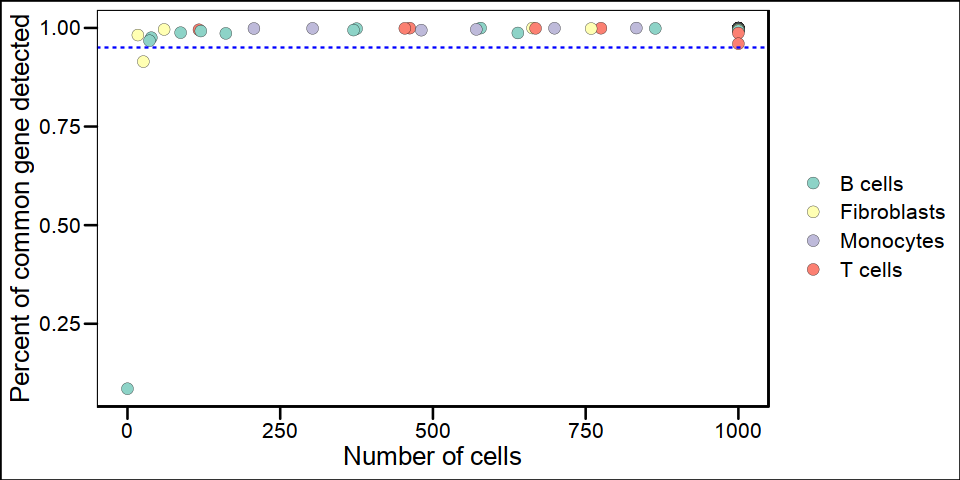

In [336]:
# Which genes are detected in 95% of samples? (# of non-zeros in log2tpm/ total # of samples)
nonzero_markers <- apply(log2tpm, 1, function(x) length(x[x>0])/length(x) > 0.95)
nonzero_genes <- log2tpm[nonzero_markers,]
common_genes <- rownames(nonzero_genes)
length(common_genes)
                         
# For a given sample, how many common genes are detected? (# of non-zeros in the common genes per sample/ total # of genes)
# If < 95%, that would be a BAD sample.
temp<-which(log2tpm[,1]>0)
common_index<-which(nonzero_markers, arr.ind=TRUE)

percentage <- array(0,dim=c(ncol(log2tpm)))
num_genes_det <- array(0,dim=c(ncol(log2tpm)))
  
for (i in 1:ncol(log2tpm)){
  temp<-which(log2tpm[,i]>0)
  num_genes_det[i] <- length(temp)
  inter<- intersect(common_index, temp)
  per<-length(inter)/length(common_genes)
  percentage[i] <- per
}
      
meta_all$percentage <- as.numeric(percentage)
meta_all[1:4,]
bad_index <- meta_all[which(meta_all$percentage < 0.95), ]$barcode
bad_index                
                         
options(repr.plot.width = 8, repr.plot.height = 4)                    
ggplot() +
    geom_point(
        data = meta_all[order(meta_all$percentage, decreasing = T),],
        mapping = aes(number_of_cells, percentage, fill = cell_type),
        shape = 21, size = 3, stroke = 0.1
    ) +
    geom_hline(yintercept = 0.95, color = "blue", linetype = "dashed") +
    scale_fill_manual(values = c("#8DD3C7", "#FFFFB3", "#BEBADA", "#FB8072"), name = "") +
    labs(
         x = "Number of cells", y = "Percent of common gene detected"
        ) +
    theme_base(base_size = 15)

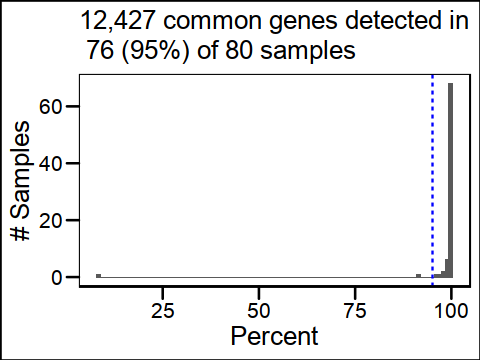

In [337]:
options(repr.plot.width = 4, repr.plot.height = 3)
ggplot(meta_all, aes(x = 100 * percentage)) +
geom_histogram(bins = 100) +
geom_vline(xintercept = 95, color = "blue", linetype = "dashed") +
scale_y_continuous(breaks = scales::pretty_breaks(4)) +
# coord_cartesian(xlim=c(80,100)) +
labs(
  x = "Percent", y = "# Samples", # title = "Percent of Common Genes",
  subtitle = sprintf(
    "%s common genes detected in\n %s (95%%) of %s samples",
    comma(length(common_genes)), ceiling(nrow(meta_all) * 0.95), nrow(meta_all)
  )
) +
theme_base(base_size = 15)
# ggsave("qc2.png", width = 5, height = 3, dpi = 300)

[1] 41727    80

[1] TRUE

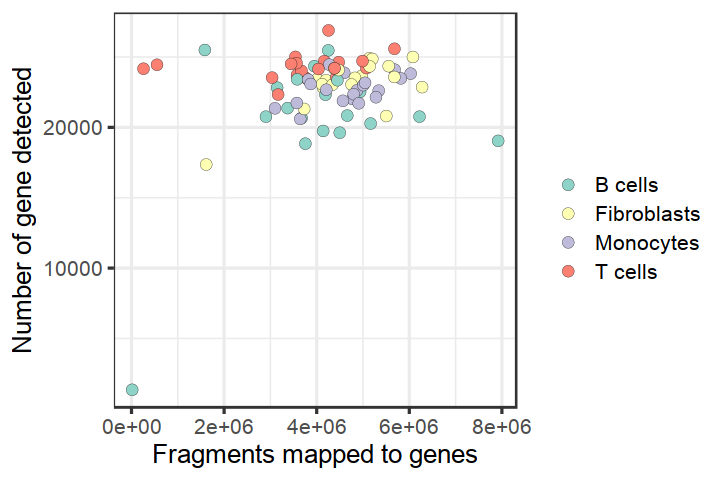

In [338]:
# Plot Mapped Fragments vs Genes Detected
# x-axis: reads/sample
# y-axis: counts of genes detected/sample

cd <- bulk$counts
cd <- cd[, which(colnames(cd) %in% colnames(log2tpm))]
dim(cd)

dat <- data.frame(
  read_count = apply(cd, 2, function(x) sum(x)),
  nGene = Matrix::colSums(cd > 0),
  barcode = colnames(cd)
)
# assert that if the sample of the dat is the same as Sample.ID
all(dat$barcode == meta_all$barcode)
meta_all$read_count <- dat$read_count
meta_all$nGene <- dat$nGene
    
options(repr.plot.width = 6, repr.plot.height = 4)
ggplot() +
  geom_point(
    data = meta_all,
    mapping = aes(read_count, nGene, fill = cell_type),
    shape = 21, size = 3, stroke = 0.1
  ) + 
  scale_fill_manual(values = c("#8DD3C7", "#FFFFB3", "#BEBADA", "#FB8072"), name = "") +
  xlab('Fragments mapped to genes')+ylab('Number of gene detected') +
#   coord_cartesian(xlim=c(0, 5e+07), ylim=c(800, 29000)) +
  theme_bw(base_size = 15) 


In [341]:
meta_all[1:4,]
saveRDS(meta_all, "bulk_meta_all.rds")
saveRDS(log2tpm, "bulk_log2tpm.rds")

barcode,well,sample,number_of_cells,cell_type,percentage,read_count,nGene
AAGAGGCA_ACTCTAGG,C09,301_0166,1000,Fibroblasts,0.9988734,4008426,23420
AAGAGGCA_AGCTAGAA,B09,300_0173,1000,Fibroblasts,0.9990344,4203594,23350
AAGAGGCA_ATAGCCTT,F09,300_0410,1000,Fibroblasts,0.9990344,4140245,22824
AAGAGGCA_CTAGTCGA,A09,300_0150,1000,Fibroblasts,0.9995172,4973800,23658


In [348]:
meta_all <- readRDS("bulk_meta_all.rds")
log2tpm <- readRDS("bulk_log2tpm.rds")
all(meta_all$barcode == colnames(log2tpm))

[1] TRUE

In [349]:
# remove the bad samples that detect < 95% of common genes
log2tpm <- log2tpm[, -which(colnames(log2tpm) %in% bad_index)]
meta_all <- meta_all[-which(meta_all$barcode %in% bad_index), ]
all(meta_all$barcode == colnames(log2tpm))
dim(log2tpm)
         
saveRDS(meta_all, "qc_bulk_meta_all.rds")
saveRDS(log2tpm, "qc_bulk_log2tpm.rds")

[1] TRUE

[1] 41727    78

In [350]:
gene_summary <- data.frame(
  mean    = rowMeans(log2tpm),
  sd      = rowSds(log2tpm),
  samples = rowSums(log2tpm > 0),
  gene = rownames(log2tpm)
)
gene_summary$mean_quantile <- rank(gene_summary$mean) / nrow(gene_summary)
gene_summary$sd_quantile   <- rank(gene_summary$sd) / nrow(gene_summary)
gene_summary$density       <- with(gene_summary, get_density(mean, sd))

# ix_na <- is.na(gene_summary$gene)
# gene_summary$gene[ix_na] <- gene_summary$ensembl_id[ix_na]

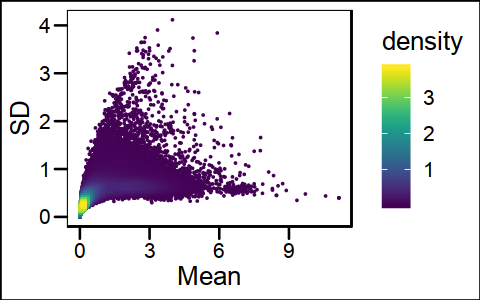

In [351]:
options(repr.plot.width = 4, repr.plot.height = 2.5)
ggplot(gene_summary[order(gene_summary$density),], aes(mean, sd, color = density)) +
scale_color_viridis() +
geom_point(size = 0.005) +
labs(x = "Mean", y = "SD") +
theme_base(base_size = 15)

In [352]:
ix_gene_mean <- gene_summary$mean > quantile(gene_summary$mean, 0.9)
ix_gene_sd <- gene_summary$sd > quantile(gene_summary$sd, 0.9)
scale_rows <- function(x) t(scale(t(x)))

temp <- log2tpm[ix_gene_mean & ix_gene_sd,]
genes_exclude <- grep("^MT-|^RPL|^RPS|MALAT1|MIR-", row.names(log2tpm), value = TRUE)
temp <- temp[-which(rownames(temp) %in% genes_exclude),]
dim(temp)

pca <- summary(prcomp(
  x = scale_rows(temp),
  center = TRUE,
  scale = TRUE
))

# meta_all <- meta_all[, -c(7:ncol(meta_all))]
meta_all <- cbind.data.frame(meta_all, pca$rotation[,1:20])
pca_var_labs <- sprintf(
  "PC%s, %.02g%% of variance",
  variance_explained(pca)$Component,
  100 * variance_explained(pca)$Variance
)

meta_all[1:4, ]

[1] 986  78

barcode,well,sample,number_of_cells,cell_type,percentage,read_count,nGene,PC1,PC2,...,PC11,PC12,PC13,PC14,PC15,PC16,PC17,PC18,PC19,PC20
AAGAGGCA_ACTCTAGG,C09,301_0166,1000,Fibroblasts,0.9988734,4008426,23420,0.1401320,-0.1234757,...,0.02169296,-0.178634052,0.05105442,-0.14658800,0.16260752,-0.07681954,0.10792510,-0.08598780,0.02757927,-0.01665709
AAGAGGCA_AGCTAGAA,B09,300_0173,1000,Fibroblasts,0.9990344,4203594,23350,0.1447246,-0.1272707,...,-0.02563206,0.030719823,-0.10485636,-0.06724404,0.02356885,-0.05080686,-0.02165261,0.07007807,-0.21549105,0.01972761
AAGAGGCA_ATAGCCTT,F09,300_0410,1000,Fibroblasts,0.9990344,4140245,22824,0.1464148,-0.1211383,...,0.02337458,0.007722327,-0.09455274,0.04510087,0.01812664,0.06015763,0.04004759,0.08317949,0.00541076,-0.01510853
AAGAGGCA_CTAGTCGA,A09,300_0150,1000,Fibroblasts,0.9995172,4973800,23658,0.1442365,-0.1156104,...,0.01363312,0.005074799,-0.09970209,0.09252258,-0.17305731,0.16097744,-0.06226427,0.08317500,0.04758452,0.03066868


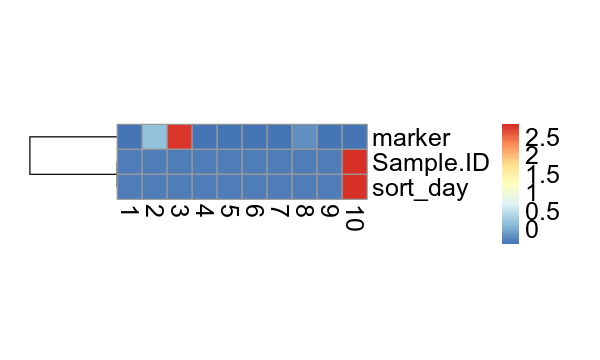

In [18]:
# # Find components of variation that are associated with known covariates:
# m_cols <- c("Sample.ID", "marker", "sort_day")
# for (col in m_cols) { 
#   meta[[col]] <- factor(meta[[col]])
# }
# m_lm <- t(sapply(m_cols, function(col) {
#   sapply(sprintf("PC%s", 1:10), function(pc) {
#     form <- as.formula(sprintf("%s ~ %s", pc, col))
#     lm1 <- summary(lm(formula = form, data = meta))
#     lm1$fstatistic[1]
#   })
# }))
# colnames(m_lm) <- 1:10

# # Scale the F statistic for each covariate, and display a heatmap:
# options(repr.plot.height = 3, repr.plot.width = 5)
# pheatmap::pheatmap(
#   mat = scale_rows(m_lm),
#   # mat = m_lm,
#   cluster_cols = FALSE,
#   fontsize = 15,
#   cellheight = 15,
#   cellwidth = 15
# )
# # dev.copy(png,file = "PCs_meta_corr.png"),width=14,height=6,units="in",res=100)
# # dev.off()

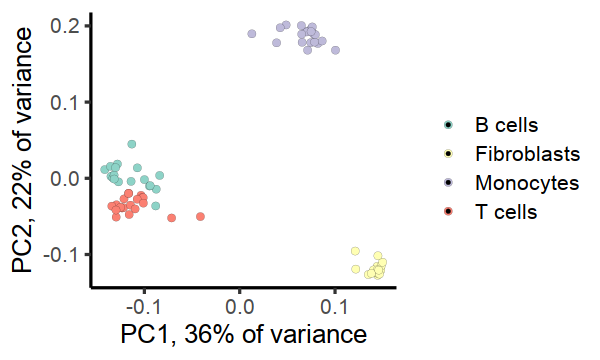

In [353]:
# Plot PCA results
options(repr.plot.height = 3, repr.plot.width = 5)
ggplot() +
  geom_point(
    data = meta_all,
    mapping = aes(PC1, PC2, fill = cell_type),
    shape = 21, size = 2, stroke = 0.05
  ) +
  geom_point(
    data = meta_all[which(meta_all$percentage < 0.95), ],
    mapping = aes(PC1, PC2, fill = cell_type),
    shape = 20, size = 1.5, stroke = 0.1
  ) +
  scale_fill_manual(values = c("#8DD3C7", "#FFFFB3", "#BEBADA", "#FB8072"), name = "") +
#   geom_text(
#     data = meta_all[which(meta_all$barcode %in% bad_index), ],
#     mapping = aes(PC1, PC2, label = barcode),
#     size = 3,
#     hjust = 0,
#     vjust = 0
#   ) +
  labs(
      x = pca_var_labs[1],
      y = pca_var_labs[2]
    ) +
  theme_classic(base_size = 15)

In [354]:
colnames(meta_all)

[1] "barcode"         "well"            "sample"          "number_of_cells"
 [5] "cell_type"       "percentage"      "read_count"      "nGene"          
 [9] "PC1"             "PC2"             "PC3"             "PC4"            
[13] "PC5"             "PC6"             "PC7"             "PC8"            
[17] "PC9"             "PC10"            "PC11"            "PC12"           
[21] "PC13"            "PC14"            "PC15"            "PC16"           
[25] "PC17"            "PC18"            "PC19"            "PC20"

# Correlation bulk with single-cell RNA-seq pseudo-bulk


In [4]:
log2tpm <- readRDS("qc_bulk_log2tpm.rds")
dim(log2tpm)
log2tpm[1:4,1:4]

[1] 41727    78

,AAGAGGCA_ACTCTAGG,AAGAGGCA_AGCTAGAA,AAGAGGCA_ATAGCCTT,AAGAGGCA_CTAGTCGA
A1BG,1.5946824,1.8617977,2.32325195,2.7772204
A1CF,0.1239807,0.1851958,0.05631817,0.1363667
A2M,2.3168538,1.1017547,1.83940469,2.0547685
A2ML1,1.4482285,1.2786532,0.97600531,0.5484352


In [5]:
exprs_norm <- readRDS("/data/srlab/fzhang/amp/results/2020_01_22_AMP_cite_seq_QC/mRNA_exprs_norm_2020-01-24.rds")
dim(exprs_norm)
exprs_norm[1:2,1:4]

[1]  33538 403596

2 x 4 sparse Matrix of class "dgCMatrix"
            BRI-399_AAACCCAAGTCATTGC BRI-399_AAACCCAAGTGAATAC
MIR1302-2HG                        .                        .
FAM138A                            .                        .
            BRI-399_AAACCCACAGTCCGTG BRI-399_AAACCCAGTAGGAGGG
MIR1302-2HG                        .                        .
FAM138A                            .                        .

In [12]:
log2tpm_rowmean <- rowMeans(log2tpm)
exprs_norm_rowmean <- Matrix::rowMeans(exprs_norm)

log2tpm_rowmean  = data.frame(
    bulk_exp = log2tpm_rowmean,
    gene = names(log2tpm_rowmean)
)

exprs_norm_rowmean = data.frame(
    sc_exp = exprs_norm_rowmean,
    gene = names(exprs_norm_rowmean)
)

length(intersect(log2tpm_rowmean$gene, exprs_norm_rowmean$gene))
length(setdiff(log2tpm_rowmean$gene, exprs_norm_rowmean$gene))
length(setdiff(exprs_norm_rowmean$gene, log2tpm_rowmean$gene))


[1] 26578

[1] 15149

[1] 6960

In [13]:
sample(setdiff(exprs_norm_rowmean$gene, log2tpm_rowmean$gene))[1:20]
sample(setdiff(log2tpm_rowmean$gene, exprs_norm_rowmean$gene))[1:20]

[1] "AC090531.1" "AC005498.3" "AP001351.1" "AC011933.3" "AL590434.1"
 [6] "AP003774.2" "PRRX2-AS1"  "NAV2-AS4"   "AC103770.1" "AC099786.1"
[11] "AC116614.1" "AC010325.2" "AC012173.1" "AC090092.1" "AC104123.1"
[16] "AC145285.6" "AC007773.1" "AP002770.1" "AC011773.1" "NDUFV2-AS1"

[1] "AL162578.1" "MGAT4EP"    "RBIS"       "RPS4XP23"   "OR5H4P"    
 [6] "RAD23BP1"   "AC040168.1" "AP001496.3" "AL512593.1" "AF131215.1"
[11] "AC008072.1" "USP9YP3"    "USP9YP34"   "ARL4AP3"    "RBM22P7"   
[16] "AC079741.1" "SHOC1"      "PAICSP7"    "MRPS36P2"   "AC138761.2"

In [7]:
library(VennDiagram)

venn.diagram(
  x = list(log2tpm_rowmean$gene, exprs_norm_rowmean$gene),
  category.names = c("Bulk" , "Single-cell" ),
  filename = 'venn_diagramm.png',
  output=TRUE
)

Loading required package: futile.logger


[1] 1

In [109]:
bulk_sc <- merge(log2tpm_rowmean, exprs_norm_rowmean, by = "gene", all = TRUE)
bulk_sc$highlight <- rep("both", nrow(bulk_sc))
dim(bulk_sc)
# bulk_sc[which(bulk_sc$gene %in% c("THY1", "CD3E", "CD14", "CCR7")),]

bulk_sc[is.na(bulk_sc)] <- 0
bulk_sc[which(bulk_sc$bulk_exp > 0 & bulk_sc$sc_exp == 0),]$highlight <- "bulk_only"
bulk_sc[which(bulk_sc$bulk_exp == 0 & bulk_sc$sc_exp > 0),]$highlight <- "sc_only"
bulk_sc$gene <- as.character(bulk_sc$gene)
table(bulk_sc$highlight)

[1] 48687     4


     both bulk_only   sc_only 
    25689     16619      6379 

In [110]:
# saveRDS(bulk_sc, "bulk_log2tpm_sc_comparison_2020-03-20.rds")

## Load the merged results of bulk and single

In [14]:
bulk_sc <- readRDS("bulk_log2tpm_sc_comparison_2020-03-20.rds")
dim(bulk_sc)
bulk_sc[1:4,]

[1] 48687     4

gene,bulk_exp,sc_exp,highlight
A1BG,2.5827489,1.571247e-01,both
A1CF,0.1849789,6.092802e-05,both
A2M,2.8429775,4.673727e-01,both
A2ML1,0.9467140,2.701487e-04,both


In [15]:
tf <- read.xls("DatabaseExtract_v_1.01.xls", sheet = 1, header = TRUE)
tf <- tf[, c(2:6)]
colnames(tf) <- c("Ensemble_ID", "gene", "DBD", "Is_TF")
tf <- tf[which(tf$Is_TF == "Yes"),]
dim(tf)
tf[1:2,]

[1] 1639    5

Ensemble_ID,gene,DBD,Is_TF,NA
ENSG00000137203,TFAP2A,AP-2,Yes,Known motif
ENSG00000008196,TFAP2B,AP-2,Yes,Known motif


### Highlight bulk only and sc only genes

In [16]:
table(bulk_sc$highlight)
length(intersect(bulk_sc$gene, tf$gene))

bulk_TF <- intersect(bulk_sc[which(bulk_sc$highlight == "bulk_only"),]$gene, tf$gene)
length(bulk_TF)

sc_TF <- intersect(bulk_sc[which(bulk_sc$highlight == "sc_only"),]$gene, tf$gene)
length(sc_TF)

length(intersect(bulk_sc[which(bulk_sc$highlight == "both"),]$gene, tf$gene))

plot_TF <- intersect(bulk_sc[which(bulk_sc$bulk_exp / bulk_sc$sc_exp > 40000),]$gene, tf$gene)
length(plot_TF)
# plot_TF 

# bulk_sc[which(bulk_sc$gene %in% c(bulk_TF, sc_TF)),]


     both bulk_only   sc_only 
    25689     16619      6379 

[1] 1630

[1] 17

[1] 15

[1] 1598

[1] 26

## Highlight TF genes

In [20]:
bulk_sc$tf_gene <- rep("No", nrow(bulk_sc))
bulk_sc$tf_gene[bulk_sc$gene %in% tf$gene] <- "Yes"
table(bulk_sc$tf_gene)


   No   Yes 
47057  1630 

In [21]:
'%!in%' <- function(x,y)!('%in%'(x,y))

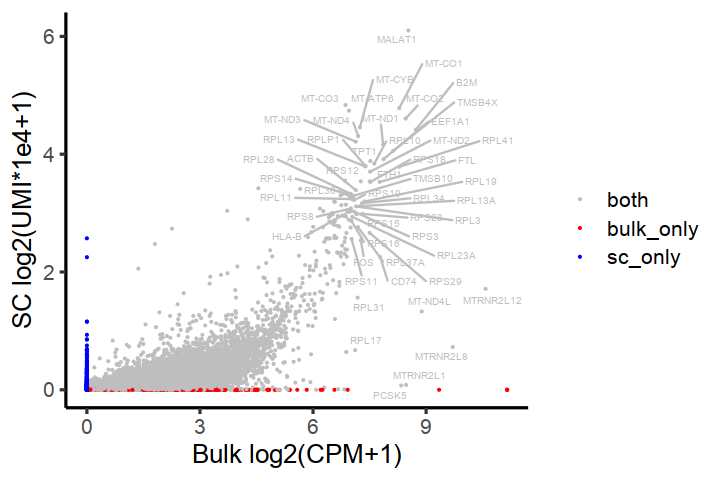


                AES   C8orf59      CTGF    FAM96B      H1FX     H2AFV     H2AFY 
    48670         1         1         1         1         1         1         1 
    H2AFZ     H3F3A     H3F3B  KIAA1551    MINOS1 POLR2J3.1     SEPT2     SEPT7 
        1         1         1         1         1         1         1         1 
    WISP2     ZFAS1 
        1         1 

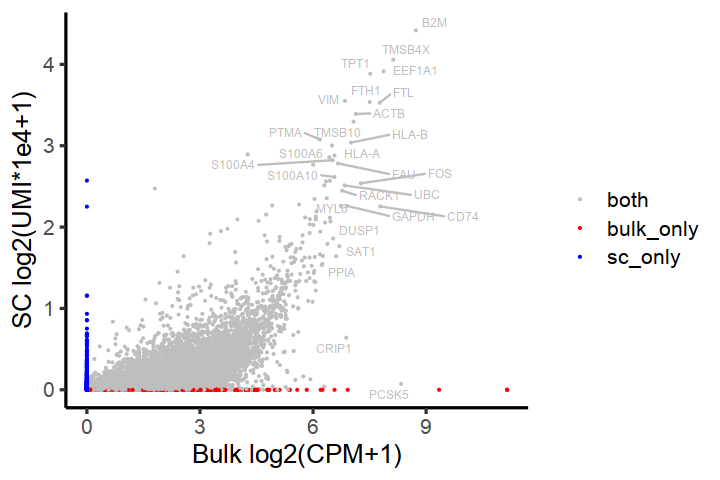


           AC010970.1 FP236383.4 FP236383.5 FP671120.7 FP671120.8      H3-3B 
     48679          1          1          1          1          1          1 
  RPL21P16    RPS28P7 
         1          1 

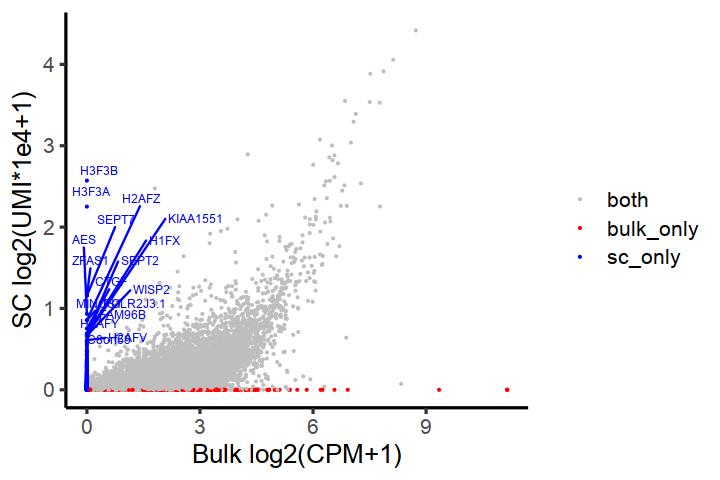

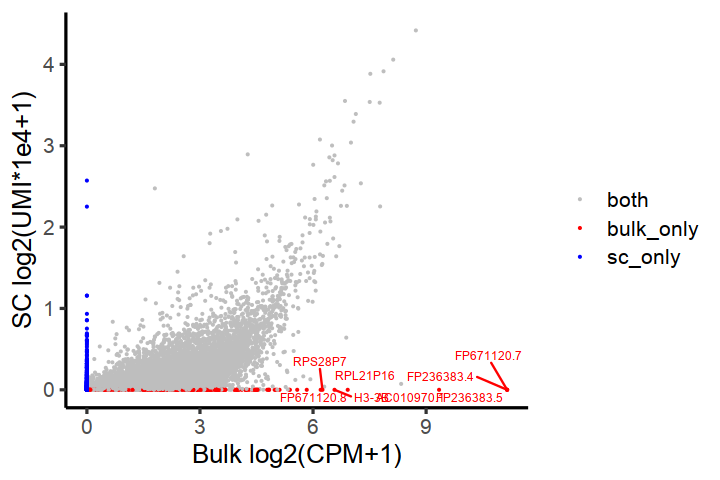

In [33]:
# Plot
options(repr.plot.height = 4, repr.plot.width = 6)

bulk_sc$label <- bulk_sc$gene
bulk_sc[bulk_sc$bulk_exp < 7 & bulk_sc$sc_exp < 4 | bulk_sc$highlight %in% c("bulk_only", "sc_only"), ]$label <- ""

ggplot(bulk_sc, aes(x = bulk_exp, y = sc_exp, color = highlight, label = label)) +
  geom_point(size = 0.1) +
  geom_text_repel(show.legend = FALSE, size =2) +
  scale_colour_manual(values = c("grey", "red", "blue"), name = "") + 
  labs(
      x = "Bulk log2(CPM+1)",
      y = "SC log2(UMI*1e4+1)"
    ) +
  theme_classic(base_size = 15)




# Plot
options(repr.plot.height = 4, repr.plot.width = 6)

bulk_sc$label <- bulk_sc$gene
bulk_sc[(bulk_sc$bulk_exp < 6.5 & bulk_sc$sc_exp < 3) | bulk_sc$highlight %in% c("bulk_only", "sc_only") , ]$label <- ""

genes_exclude <- grep("^MT-|^RPL|^RPS|MALAT1|MIR-|^MTRNR", row.names(exprs_norm), value = TRUE)
temp <- bulk_sc[-which(bulk_sc$gene %in% genes_exclude),]

ggplot(temp, aes(x = bulk_exp, y = sc_exp, color = highlight, label = label)) +
  geom_point(size = 0.1) +
  geom_text_repel(show.legend = FALSE, size =2.5) +
  scale_colour_manual(values = c("grey", "red", "blue"), name = "") + 
#   coord_cartesian(xlim = c(0, 11), ylim = c(0, 11)) +
  labs(
      x = "Bulk log2(CPM+1)",
      y = "SC log2(UMI*1e4+1)"
    ) +
  theme_classic(base_size = 15)




# Plot
options(repr.plot.height = 4, repr.plot.width = 6)

bulk_sc$label <- bulk_sc$gene
bulk_sc[which( bulk_sc$highlight %!in% "sc_only" | bulk_sc$sc_exp < 0.6 ), ]$label <- ""
table(bulk_sc$label)

genes_exclude <- grep("^MT-|^RPL|^RPS|MALAT1|MIR-|^MTRNR", row.names(exprs_norm), value = TRUE)
temp <- bulk_sc[-which(bulk_sc$gene %in% genes_exclude),]

ggplot(temp, aes(x = bulk_exp, y = sc_exp, color = highlight, label = label)) +
  geom_point(size = 0.1) +
  geom_text_repel(show.legend = FALSE, size =2.5) +
  scale_colour_manual(values = c("grey", "red", "blue"), name = "") + 
#   coord_cartesian(xlim = c(0, 11), ylim = c(0, 11)) +
  labs(
      x = "Bulk log2(CPM+1)",
      y = "SC log2(UMI*1e4+1)"
    ) +
  theme_classic(base_size = 15)




# Plot
options(repr.plot.height = 4, repr.plot.width = 6)

bulk_sc$label <- bulk_sc$gene
bulk_sc[which( bulk_sc$highlight %!in% "bulk_only" | bulk_sc$bulk_exp < 6 ), ]$label <- ""
table(bulk_sc$label)

genes_exclude <- grep("^MT-|^RPL|^RPS|MALAT1|MIR-|^MTRNR", row.names(exprs_norm), value = TRUE)
temp <- bulk_sc[-which(bulk_sc$gene %in% genes_exclude),]

ggplot(temp, aes(x = bulk_exp, y = sc_exp, color = highlight, label = label)) +
  geom_point(size = 0.1) +
  geom_text_repel(show.legend = FALSE, size =2.5) +
  scale_colour_manual(values = c("grey", "red", "blue"), name = "") + 
#   coord_cartesian(xlim = c(0, 11), ylim = c(0, 11)) +
  labs(
      x = "Bulk log2(CPM+1)",
      y = "SC log2(UMI*1e4+1)"
    ) +
  theme_classic(base_size = 15)

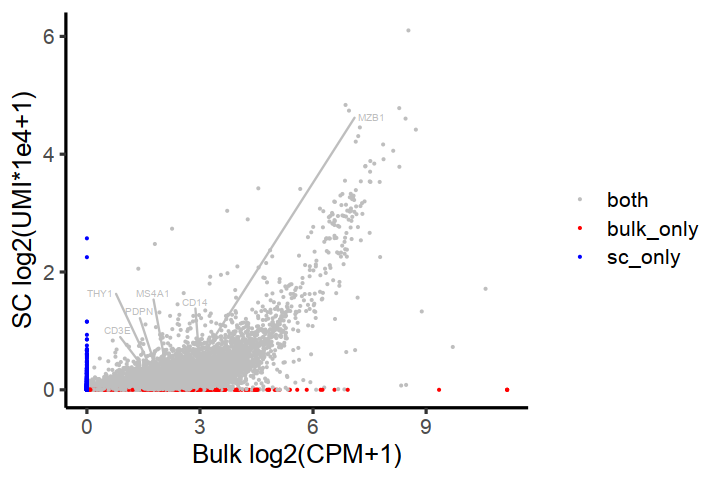

In [115]:
# Plot
options(repr.plot.height = 4, repr.plot.width = 6)

bulk_sc$label <- bulk_sc$gene
bulk_sc[which(bulk_sc$gene %!in% c("CD3E", "CD14", "PDPN", "MS4A1", "THY1", "MZB1")),]$label <- ""

ggplot(bulk_sc, aes(x = bulk_exp, y = sc_exp, color = highlight, label = label)) +
  geom_point(size = 0.1) +
  geom_text_repel(show.legend = FALSE, size = 2) +
  scale_colour_manual(values = c("grey", "red", "blue"), name = "") + 
  labs(
      x = "Bulk log2(CPM+1)",
      y = "SC log2(UMI*1e4+1)"
    ) +
  theme_classic(base_size = 15)



         ATF4  ATF6B   EGR1    FOS   FOSB  GTF3A  HIF1A   IRF1   IRF9   JUNB 
 47401      1      1      1      1      1      1      1      1      1      1 
  JUND  KLF15   KLF6   NME2  NR4A1  NR4A2   RBPJ    SON  SP100  STAT6 ZNF207 
     1      1      1      1      1      1      1      1      1      1      1 
ZNF331 ZNF706 
     1      1 

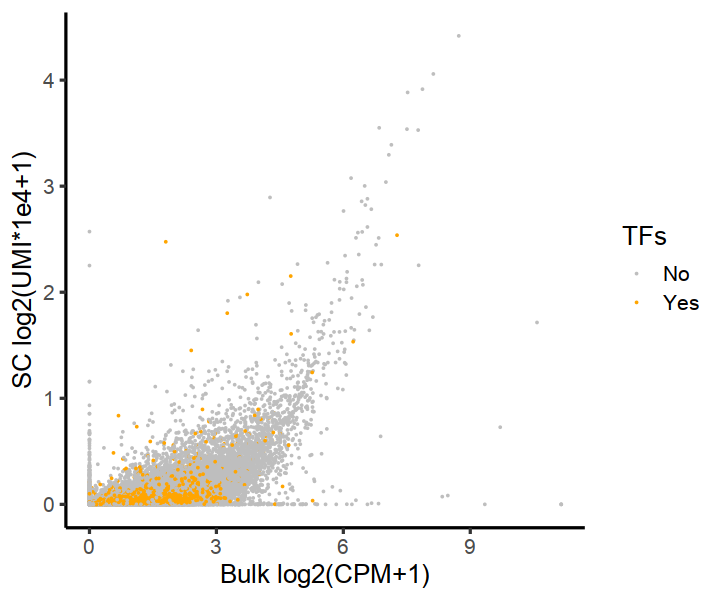

In [65]:
# Plot
genes_exclude <- grep("^MT-|^RPL|^RPS|MALAT1|MIR-", row.names(log2tpm), value = TRUE)
temp <- bulk_sc[-which(bulk_sc$gene %in% genes_exclude),]
temp$label <- temp$gene
temp[(temp$bulk_exp < 4 & temp$sc_exp < 2) | temp$tf_gene == "No", ]$label <- ""
table(temp$label)

options(repr.plot.height = 5, repr.plot.width = 6)
ggplot(temp,
#        temp[order(bulk_sc$tf_gene),], 
       aes(x = bulk_exp, y = sc_exp, color = tf_gene, label = label)) +
  geom_point(size = 0.001) +
#   scale_x_log10() +
#   scale_y_log10() +
  geom_text_repel(show.legend = FALSE, size = 3) +
  scale_colour_manual(values = c("grey", "orange"), name = "TFs") + 
#   coord_cartesian(xlim = c(0, 11), ylim = c(0, 11)) +
  labs(
      x = "Bulk log2(CPM+1)",
      y = "SC log2(UMI*1e4+1)"
    ) +
  theme_classic(base_size = 15)

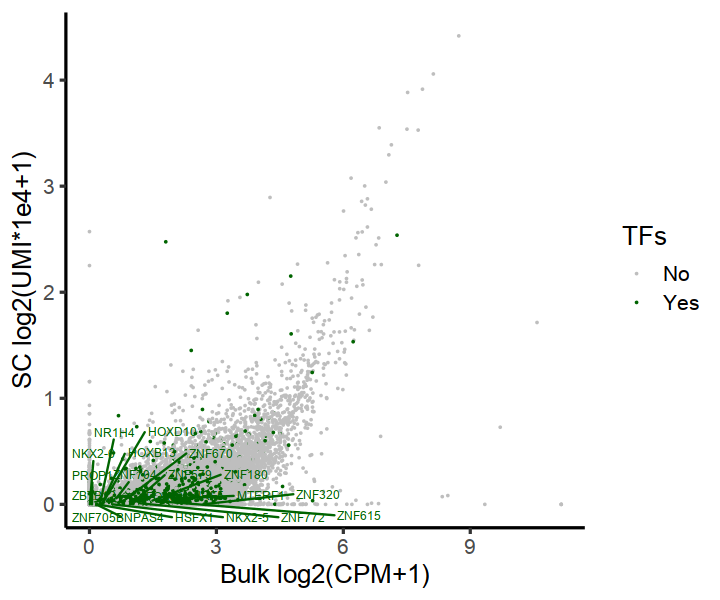

In [52]:
genes_exclude <- grep("^MT-|^RPL|^RPS|MALAT1|MIR-", row.names(log2tpm), value = TRUE)
temp <- bulk_sc[-which(bulk_sc$gene %in% genes_exclude),]
temp$label <- temp$gene
tf_low <- sample(temp[temp$bulk_exp < 3 & temp$sc_exp < 0.1 & temp$tf_gene == "Yes", ]$label, 20)
temp[which(temp$gene %!in% tf_low),]$label <- ""

options(repr.plot.height = 5, repr.plot.width = 6)
ggplot(temp,
#        temp[order(bulk_sc$tf_gene),], 
       aes(x = bulk_exp, y = sc_exp, color = tf_gene, label = label)) +
  geom_point(size = 0.001) +
  geom_text_repel(show.legend = FALSE, size =2.5, point.padding = NA) +
  scale_colour_manual(values = c("grey", "darkgreen"), name = "TFs") + 
#   coord_cartesian(xlim = c(0, 11), ylim = c(0, 11)) +
  labs(
      x = "Bulk log2(CPM+1)",
      y = "SC log2(UMI*1e4+1)"
    ) +
  theme_classic(base_size = 15)

In [66]:
temp <- bulk_sc[-which(bulk_sc$gene %in% genes_exclude),]
temp$label <- temp$gene
tf_low <- sample(temp[temp$bulk_exp < 3 & temp$sc_exp < 0.1 & temp$tf_gene == "Yes", ]$label, 20)
tf_low

[1] "NKX2-4"  "SHOX"    "ZBTB45"  "HOXD9"   "ZNF532"  "SOX2"    "HMX3"   
 [8] "ZNF423"  "ERG"     "NR1I3"   "FOXD4L5" "EVX2"    "ZNF461"  "NR1D1"  
[15] "BARHL1"  "ZNF764"  "POU2AF1" "ZNF497"  "TET3"    "PRDM15"

In [ ]:
# Plot
options(repr.plot.height = 5, repr.plot.width = 6)

temp$label <- temp$gene
temp[temp$label %!in% "IL17A", ]$label <- ""
table(temp$label)

ggplot(temp,
#        temp[order(bulk_sc$tf_gene),], 
       aes(x = bulk_exp, y = sc_exp, color = label, label = label)) +
  geom_point(size = 0.001) +
#   scale_x_log10() +
#   scale_y_log10() +
  geom_text_repel(show.legend = FALSE, size =2.5) +
  scale_colour_manual(values = c("grey", "green"), name = "TFs") + 
#   coord_cartesian(xlim = c(0, 11), ylim = c(0, 11)) +
  labs(
      x = "Bulk log2(CPM+1)",
      y = "SC log2(UMI*1e4+1)"
    ) +
  theme_classic(base_size = 15)


      IL17A 
48557     1 

In [6]:
'%!in%' <- function(x,y)!('%in%'(x,y))


           AC138696.1       ANHX      ARGFX      ATOH1        BSX       CDX4 
     48661          1          1          1          1          1          1 
    DMRTB1     DMRTC2       DUX4      HSFX2      HSFY1        ISX      LEUTX 
         1          1          1          1          1          1          1 
     MSGN1    NEUROD6     NKX2-6       PAX4      PRDM9      RBPJL      SEBOX 
         1          1          1          1          1          1          1 
     SOX14      TFDP3      TPRX1    ZNF705B     ZNF735    ZSCAN5C 
         1          1          1          1          1          1 

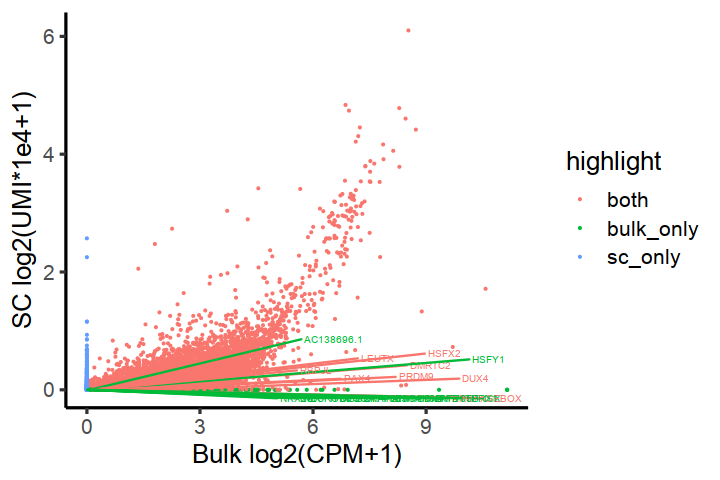

In [51]:
# Plot TFs
options(repr.plot.height = 4, repr.plot.width = 6)

bulk_sc$label <- bulk_sc$gene
bulk_sc$label[bulk_sc$gene %!in% plot_TF] <- ""
table(bulk_sc$label)

ggplot(bulk_sc, aes(x = bulk_exp, y = sc_exp, color = highlight, label = label)) +
  geom_point(size = 0.1) +
  geom_text_repel(show.legend = FALSE, size = 2) +
  labs(
      x = "Bulk log2(CPM+1)",
      y = "SC log2(UMI*1e4+1)"
    ) +
  theme_classic(base_size = 15)

## Each cell type

In [133]:
sc_meta <- readRDS("/data/srlab/fzhang/amp/results/2020_01_22_AMP_cite_seq_QC/qc_mRNA_protein_pca_umap_clus_meta_all_site_anno_hpca_2020-02-23.rds")
cell_tcell <- sc_meta[which(sc_meta$res_0.60 %in% c(1,3,8,12)),]$cell
length(cell_tcell)

sc_expr <- readRDS("/data/srlab/fzhang/amp/results/2020_01_22_AMP_cite_seq_QC/qc_mRNA_exprs_2020-01-24.rds")
tcell_sc_expr <- sc_expr[, cell_tcell]
tcell_sc_expr <- tcell_sc_expr %>% NormalizeDataSeurat()
dim(tcell_sc_expr)

[1]  33538 122876

In [134]:
log2tpm <- readRDS("qc_bulk_log2tpm.rds")
meta_all <- readRDS("qc_bulk_meta_all.rds")
tcell_log2tpm <- log2tpm[, which(meta_all$cell_type == "Fibroblasts")]
dim(tcell_log2tpm)

[1] 41727    19

In [135]:
tcell_log2tpm_rowmean <- rowMeans(tcell_log2tpm)
tcell_sc_expr_rowmean <- Matrix::rowMeans(tcell_sc_expr)

tcell_log2tpm_rowmean  = data.frame(
    bulk_exp = tcell_log2tpm_rowmean,
    gene = names(tcell_log2tpm_rowmean)
)

tcell_sc_expr_rowmean = data.frame(
    sc_exp = tcell_sc_expr_rowmean,
    gene = names(tcell_sc_expr_rowmean)
)

length(intersect(tcell_log2tpm_rowmean$gene, tcell_sc_expr_rowmean$gene))
length(setdiff(tcell_log2tpm_rowmean$gene, tcell_sc_expr_rowmean$gene))
length(setdiff(tcell_sc_expr_rowmean$gene, tcell_log2tpm_rowmean$gene))

[1] 26578

[1] 15149

[1] 6960

## Load the bulk meta data and saved it for Bill

In [5]:
meta <- readRDS("bulk_meta_all.rds")
dim(meta)

[1] 80  8

In [8]:
table(meta$cell_type)
meta[1:4,]


    B cells Fibroblasts   Monocytes     T cells 
         20          20          20          20 

barcode,well,sample,number_of_cells,cell_type,percentage,read_count,nGene
AAGAGGCA_ACTCTAGG,C09,301_0166,1000,Fibroblasts,0.9988734,4008426,23420
AAGAGGCA_AGCTAGAA,B09,300_0173,1000,Fibroblasts,0.9990344,4203594,23350
AAGAGGCA_ATAGCCTT,F09,300_0410,1000,Fibroblasts,0.9990344,4140245,22824
AAGAGGCA_CTAGTCGA,A09,300_0150,1000,Fibroblasts,0.9995172,4973800,23658


In [7]:
"AAGAGGCA_ACTCTAGG" %in% meta$barcode

[1] TRUE

In [9]:
write.table(meta, file = paste("amp_phase2_bulk_meta_data", ".txt", sep = ""),
             row.names=T,col.names=T, quote = F, sep = "\t")